In [3]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append('..')
from prediction_denoise import prediction
from glob import glob
import numpy as np
import librosa
import IPython.display as ipd
from signal_utils import audio_files_to_numpy, numpy_audio_to_matrix_spectrogram, snr_db, psnr, apply_noise
from data_plot import plot_spectrogram, plot_3_spectograms
import matplotlib.pyplot as plt

In [4]:
def predict(audio_input_prediction, audio_output_prediction, sr=8000, name_model='model_unet', path='..\\data\\validation\\'):
    # path to find pre-trained weights / save models
    weights_path = '..\\data\\weights'
    # pre trained model
    name_model = name_model
    # directory where read noisy sound to denoise
    audio_dir_prediction = f'{path}noisy_voice'
    # directory to save the denoise sound
    dir_save_prediction = f'{path}save_prediction\\'
    # Name noisy sound file to denoise
    audio_input_prediction = [audio_input_prediction]
    # Name of denoised sound file to save
    audio_output_prediction = audio_output_prediction
    # Sample rate to read audio
    sample_rate = sr
    # Minimum duration of audio files to consider
    min_duration = 1.0
    # Frame length for training data
    frame_length = 8064
    # hop length for sound files
    hop_length_frame = 8064
    # nb of points for fft(for spectrogram computation)
    n_fft = 255
    # hop length for fft
    hop_length_fft = 63
    
    prediction(weights_path, name_model, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
               audio_output_prediction, sample_rate, min_duration, frame_length, hop_length_frame, n_fft,
               hop_length_fft)

# Comparision of different SNR

## Read clean voices

In [5]:
clean_voices_list = glob('..\\data\\snr_test\\clean_voice\\*')
clean_voices_list = [os.path.basename(voice) for voice in clean_voices_list]
print(clean_voices_list)

['marcin_clean.wav']


## Read noises

In [6]:
noises_list = glob('..\\data\\snr_test\\noise\\*')
noises_list = [os.path.basename(noise) for noise in noises_list]
print(noises_list)

['birds.wav', 'keyboard.wav']


## Apply noise and compare

In [27]:
def create_noise_files(noise_name):
    multipliers = [0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 1, 1.1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 14, 20, 30, 50, 100]
    s, fs = librosa.load(os.path.join('..\\data\\snr_test\\clean_voice', clean_voices_list[0]))
    s_norm = librosa.util.normalize(s)
    snrs = []
    n, _ = librosa.load(os.path.join('..\\data\\snr_test\\noise', noise_name))
    n_norm = librosa.util.normalize(n)
    for i, multiplier in enumerate(multipliers):
        snrs.append(snr_db(s_norm, n_norm * multiplier))
        apply_noise('..\\data\\snr_test\\noisy_voice\\',
                                   f'{clean_voices_list[0][:-9]}{i}_{noise_name}', s_norm, n_norm * multiplier, fs)
    print(snrs)
    
def denoise_files():
    noisy_voices_list = sorted(glob('..\\data\\snr_test\\noisy_voice\\*'), key=len)
    noisy_voices_list = [os.path.basename(voice) for voice in noisy_voices_list]
    print(noisy_voices_list)
    
    for voice in noisy_voices_list:
        predict(audio_input_prediction=voice, audio_output_prediction=f'pred_{voice}', path='..\\data\\snr_test\\')
        
def calculate_psnrs():
    original, fs = librosa.load(os.path.join('..\\data\\snr_test\\clean_voice', clean_voices_list[0]))
    original_norm = librosa.util.normalize(original)
    # predicted_voices_list = glob('..\\data\\snr_test\\save_prediction\\*')
    predicted_voices_list = sorted(glob('..\\data\\snr_test\\save_prediction\\*'), key=len)
    predicted_voices_list = [os.path.basename(voice) for voice in predicted_voices_list]
    print(predicted_voices_list)

    psnrs = []
    for voice in predicted_voices_list:
        pred, fs = librosa.load(os.path.join('..\\data\\snr_test\\save_prediction', voice))
        psnrs.append(psnr(original_norm[:pred.shape[0]], pred))
    print(psnrs)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(snrs, psnrs)
    ax.invert_xaxis()
    ax.set_xlabel('SNR [dB]')
    ax.set_ylabel('PSNR predict to clean [dB]')
    
def clean_files():
    files = glob('..\\data\\snr_test\\save_prediction\\*')
    for f in files:
        os.remove(f)
        
    files = glob('..\\data\\snr_test\\noisy_voice\\*')
    for f in files:
        os.remove(f) 

## Marcin voice - keyboard noise

In [29]:
%%capture
clean_files()
create_noise_files('keyboard.wav')
denoise_files()

### Input SNR and predicted PSNR relationship

['pred_marcin_0_keyboard.wav', 'pred_marcin_1_keyboard.wav', 'pred_marcin_2_keyboard.wav', 'pred_marcin_3_keyboard.wav', 'pred_marcin_4_keyboard.wav', 'pred_marcin_5_keyboard.wav', 'pred_marcin_6_keyboard.wav', 'pred_marcin_7_keyboard.wav', 'pred_marcin_8_keyboard.wav', 'pred_marcin_9_keyboard.wav', 'pred_marcin_10_keyboard.wav', 'pred_marcin_11_keyboard.wav', 'pred_marcin_12_keyboard.wav', 'pred_marcin_13_keyboard.wav', 'pred_marcin_14_keyboard.wav', 'pred_marcin_15_keyboard.wav', 'pred_marcin_16_keyboard.wav', 'pred_marcin_17_keyboard.wav', 'pred_marcin_18_keyboard.wav', 'pred_marcin_19_keyboard.wav', 'pred_marcin_20_keyboard.wav']
[25.0, 24.96, 24.95, 24.95, 24.96, 24.94, 24.92, 24.91, 24.83, 24.63, 24.08, 23.34, 22.04, 20.28, 19.51, 19.04, 18.73, 18.56, 18.4, 18.33, 18.28]


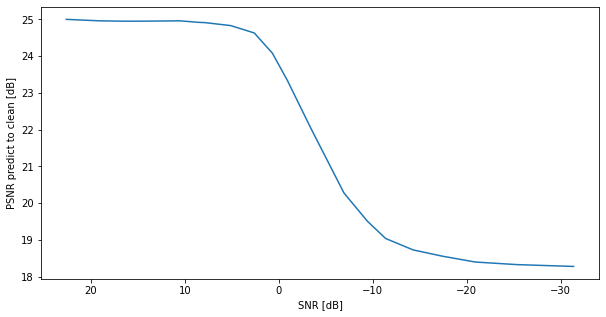

In [30]:
calculate_psnrs()

## Marcin voice - birds noise

In [31]:
%%capture
clean_files()
create_noise_files('birds.wav')
denoise_files()

### Input SNR and predicted PSNR relationship

['pred_marcin_0_birds.wav', 'pred_marcin_1_birds.wav', 'pred_marcin_2_birds.wav', 'pred_marcin_3_birds.wav', 'pred_marcin_4_birds.wav', 'pred_marcin_5_birds.wav', 'pred_marcin_6_birds.wav', 'pred_marcin_7_birds.wav', 'pred_marcin_8_birds.wav', 'pred_marcin_9_birds.wav', 'pred_marcin_10_birds.wav', 'pred_marcin_11_birds.wav', 'pred_marcin_12_birds.wav', 'pred_marcin_13_birds.wav', 'pred_marcin_14_birds.wav', 'pred_marcin_15_birds.wav', 'pred_marcin_16_birds.wav', 'pred_marcin_17_birds.wav', 'pred_marcin_18_birds.wav', 'pred_marcin_19_birds.wav', 'pred_marcin_20_birds.wav']
[24.7, 24.48, 24.17, 23.91, 22.93, 22.49, 22.06, 21.71, 20.6, 19.7, 19.24, 18.98, 18.72, 18.48, 18.37, 18.31, 18.24, 18.2, 18.16, 18.14, 18.12]


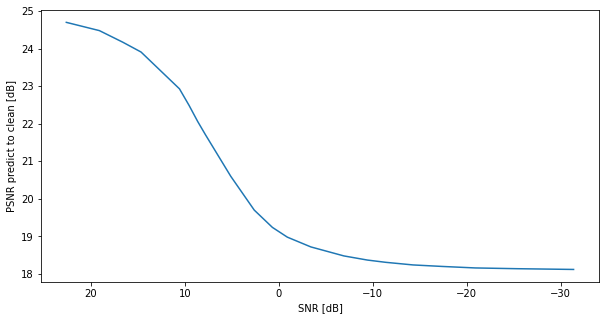

In [32]:
calculate_psnrs()

## Marcin voice - mouseclicks noise

In [35]:
%%capture
clean_files()
create_noise_files('mouse.wav')
denoise_files()

### Input SNR and predicted PSNR relationship

['pred_marcin_0_mouse.wav', 'pred_marcin_1_mouse.wav', 'pred_marcin_2_mouse.wav', 'pred_marcin_3_mouse.wav', 'pred_marcin_4_mouse.wav', 'pred_marcin_5_mouse.wav', 'pred_marcin_6_mouse.wav', 'pred_marcin_7_mouse.wav', 'pred_marcin_8_mouse.wav', 'pred_marcin_9_mouse.wav', 'pred_marcin_10_mouse.wav', 'pred_marcin_11_mouse.wav', 'pred_marcin_12_mouse.wav', 'pred_marcin_13_mouse.wav', 'pred_marcin_14_mouse.wav', 'pred_marcin_15_mouse.wav', 'pred_marcin_16_mouse.wav', 'pred_marcin_17_mouse.wav', 'pred_marcin_18_mouse.wav', 'pred_marcin_19_mouse.wav', 'pred_marcin_20_mouse.wav']
[25.19, 25.13, 25.05, 25.0, 24.93, 24.93, 24.92, 24.91, 24.84, 24.71, 24.47, 24.08, 23.46, 22.79, 22.46, 22.3, 21.68, 20.74, 19.82, 18.99, 18.48]


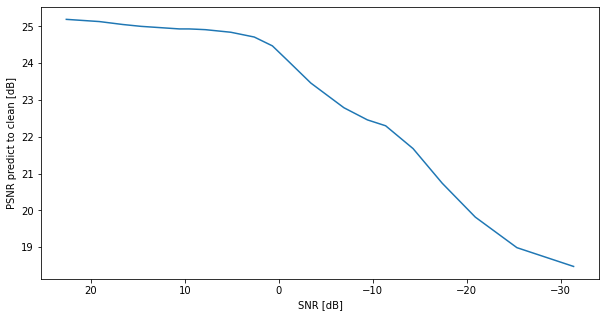

In [36]:
calculate_psnrs()